In [96]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import pandas as pd

In [97]:
import os

root = 'plates'
test_p = []
train_cleaned = []
train_dirty = []

for folder in os.listdir(root):
    path_to_folder = os.path.join(root, folder)
    if folder == 'test':
        for im in os.listdir(path_to_folder):
            test_p.append(os.path.join(path_to_folder, im))
    else:
        for target_folder in os.listdir(path_to_folder):
            path_to_train_im = os.path.join(path_to_folder, target_folder)
            for im in os.listdir(path_to_train_im):
                train_cleaned.append(os.path.join(path_to_train_im, im)) if target_folder == 'cleaned' else train_dirty.append(os.path.join(path_to_train_im, im))

In [98]:
len(test_p), len(train_cleaned), len(train_dirty)

(744, 21, 21)

In [99]:
train_cleaned.pop(0)
train_dirty.pop(0)

'plates\\train\\dirty\\.DS_Store'

In [100]:
len(test_p), len(train_cleaned), len(train_dirty)

(744, 20, 20)

In [101]:
def convert_to_array(path_to_im):
    return torchvision.io.read_image(path_to_im)

test = list(map(lambda x: convert_to_array(x), test_p))
train_cleaned = list(map(lambda x: convert_to_array(x), train_cleaned))
train_dirty = list(map(lambda x: convert_to_array(x), train_dirty))

In [102]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)),
    ])

test = [transform(img) for img in test]
train_cleaned = [transform(img) for img in train_cleaned]
train_dirty = [transform(img) for img in train_dirty]

In [103]:
label_cleaned = 0
train_cleaned = [(x, label_cleaned) for x in train_cleaned]

label_dirty = 1
train_dirty = [(x, label_dirty) for x in train_dirty]

In [104]:
import random
train = train_cleaned + train_dirty
random.shuffle(train)

In [177]:
import torchvision.transforms as T

train_transform = T.Compose([
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
    T.RandomResizedCrop(224, scale=(0.6, 1.0)),
    T.RandomPerspective(distortion_scale=0.3),
    T.RandomAdjustSharpness(2)
])

In [ ]:
import torchvision.models as models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [180]:
num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0.0
    for image, label in train:
        image = image.float() / 255.0
        image = nn.functional.interpolate(image.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False)
        image = train_transform(image[0]).unsqueeze(0)
        label = torch.tensor([[label]], dtype=torch.float)
        outputs = model(image)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 29.3418
Epoch 2, Loss: 28.6083
Epoch 3, Loss: 28.0424
Epoch 4, Loss: 28.9241
Epoch 5, Loss: 28.3352
Epoch 6, Loss: 27.4707
Epoch 7, Loss: 26.3684
Epoch 8, Loss: 24.7352
Epoch 9, Loss: 21.8178
Epoch 10, Loss: 19.9434
Epoch 11, Loss: 16.2135
Epoch 12, Loss: 14.2805
Epoch 13, Loss: 16.1043
Epoch 14, Loss: 11.9022
Epoch 15, Loss: 9.1969
Epoch 16, Loss: 7.5289
Epoch 17, Loss: 5.9263
Epoch 18, Loss: 7.8328
Epoch 19, Loss: 13.3895
Epoch 20, Loss: 6.1418


In [181]:
result = []

for image in test:
    image = image.float().unsqueeze(0) / 255.0
    label = torch.tensor([label])

    outputs = model(image)
    prob = torch.sigmoid(outputs)
    pred = (prob > 0.1).long()
    result.append(['cleaned', 'dirty'][pred.item()])

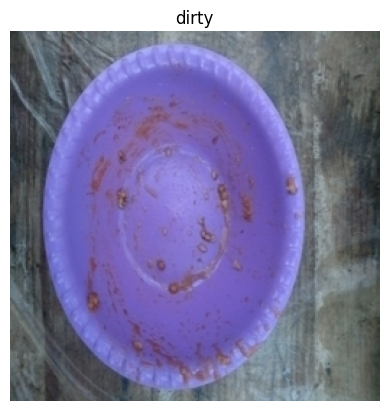

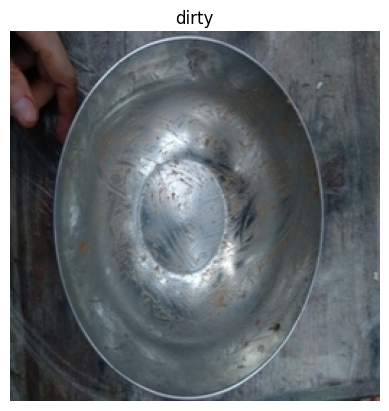

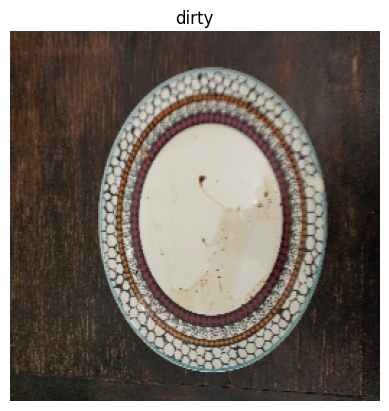

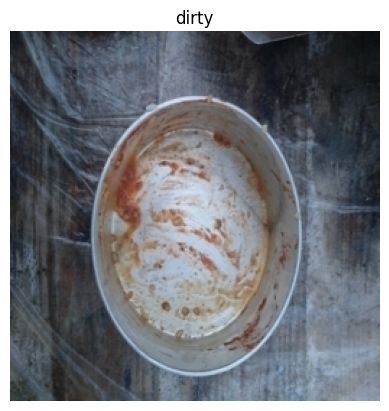

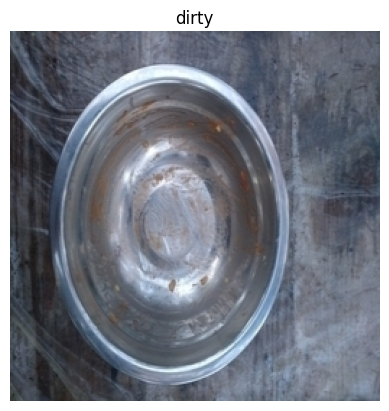

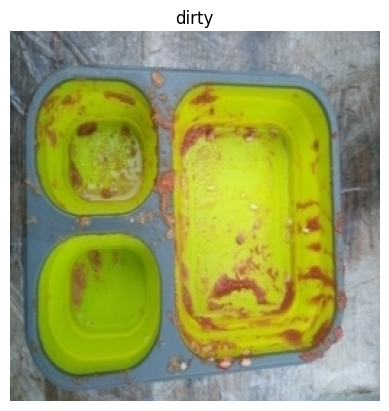

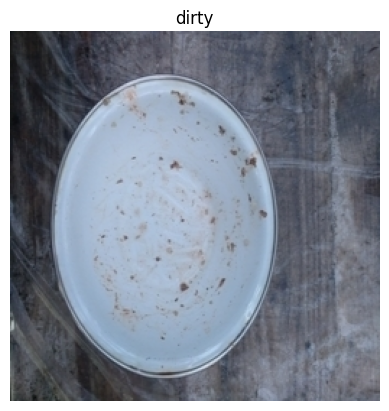

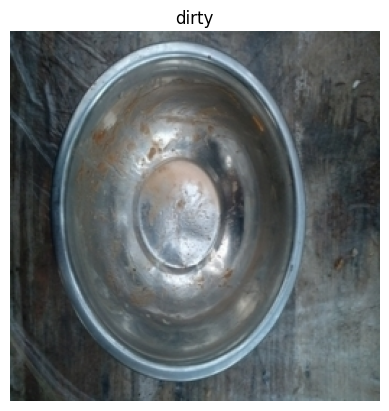

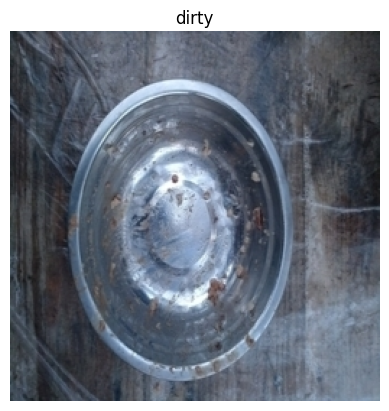

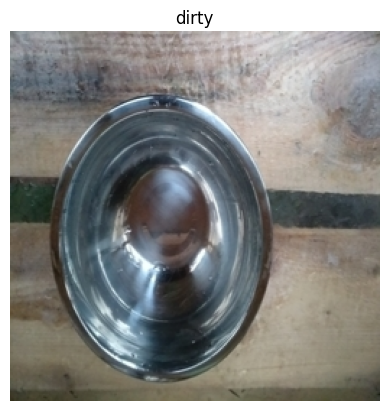

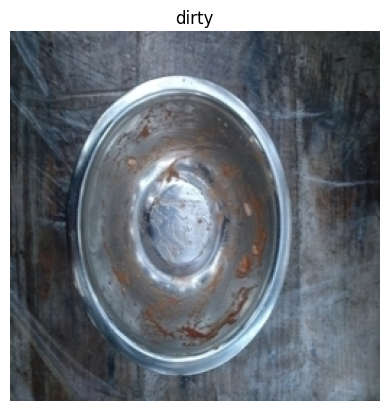

In [182]:
import matplotlib.pyplot as plt

for i, (res, image) in enumerate(zip(result, test)):
    if i > 10:
        break
    plt.imshow(image.permute(1, 2, 0))
    plt.title(res)
    plt.axis('off')
    plt.show()

In [183]:
len(result)

744

In [184]:
def get_id(x):
    name_image = x.split('\\')[-1]
    return name_image.split('.')[0]
id = list(map(get_id, test_p))

In [185]:
id = pd.Series(id, name='id')
result = pd.Series(result, name='label')

table = pd.concat([id.to_frame(), result.to_frame()], axis=1)

In [186]:
table.head()

,id,label
0,0000,dirty
1,0001,dirty
2,0002,dirty
3,0003,dirty
4,0004,dirty


In [188]:
table.to_csv('sample_submission.csv', index=False)